In [1]:
#import date and time 
!pip install datetime
!pip install nsetools
import datetime as dt
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
#import pandas datareader
#import nsetools data
import pandas_datareader.data as web
%matplotlib inline

In [2]:
tickers = ['IDEA.NS', 'UVSL.NS', 'TATAMOTORS.NS', 'ONGC.NS']
merged = False
for i in tickers:
    finance_data = yf.Ticker(i)
    data = finance_data.history(period="10y")
    data.reset_index(inplace=True)
    data[i] = (data['Close']/data['Close'].shift(1)) - 1
    data.to_csv(i +".csv")
    #set the timings 
    start = dt.datetime(2010,1,1)
    end = dt.datetime(2019,1,1)
    #import nse data
    df=web.DataReader('^NSEI','yahoo',start,end)
    print(df.head(16))
    data = data[['Date',  i]]
    data.set_index('Date', inplace = True)
    if merged:
        all_data = pd.concat([all_data, data], axis = 1)
    else:
        all_data = data
        merged = True
all_data.dropna(inplace=True)

                   High          Low         Open        Close  Volume  \
Date                                                                     
2010-01-04  5238.450195  5167.100098  5200.899902  5232.200195     0.0   
2010-01-05  5288.350098  5242.399902  5277.149902  5277.899902     0.0   
2010-01-06  5310.850098  5260.049805  5278.149902  5281.799805     0.0   
2010-01-07  5302.549805  5244.750000  5281.799805  5263.100098     0.0   
2010-01-08  5276.750000  5234.700195  5264.250000  5244.750000     0.0   
2010-01-11  5287.200195  5227.799805  5263.799805  5249.399902     0.0   
2010-01-12  5300.500000  5200.950195  5251.100098  5210.399902     0.0   
2010-01-13  5239.200195  5169.549805  5212.600098  5233.950195     0.0   
2010-01-14  5272.850098  5232.500000  5234.500000  5259.899902     0.0   
2010-01-15  5279.850098  5242.450195  5259.899902  5252.200195     0.0   
2010-01-18  5292.500000  5228.950195  5253.649902  5274.850098     0.0   
2010-01-19  5287.799805  5218.649902  

In [3]:
all_data.describe().transpose()
all_data.to_csv("all_data.csv")

In [6]:
all_data.corr().style.background_gradient(cmap='Blues', axis=None).set_precision(2)

,IDEA.NS,UVSL.NS,TATAMOTORS.NS,ONGC.NS
IDEA.NS,1.00,-0.03,0.19,0.11
UVSL.NS,-0.03,1.00,-0.02,0.02
TATAMOTORS.NS,0.19,-0.02,1.00,0.35
ONGC.NS,0.11,0.02,0.35,1.00


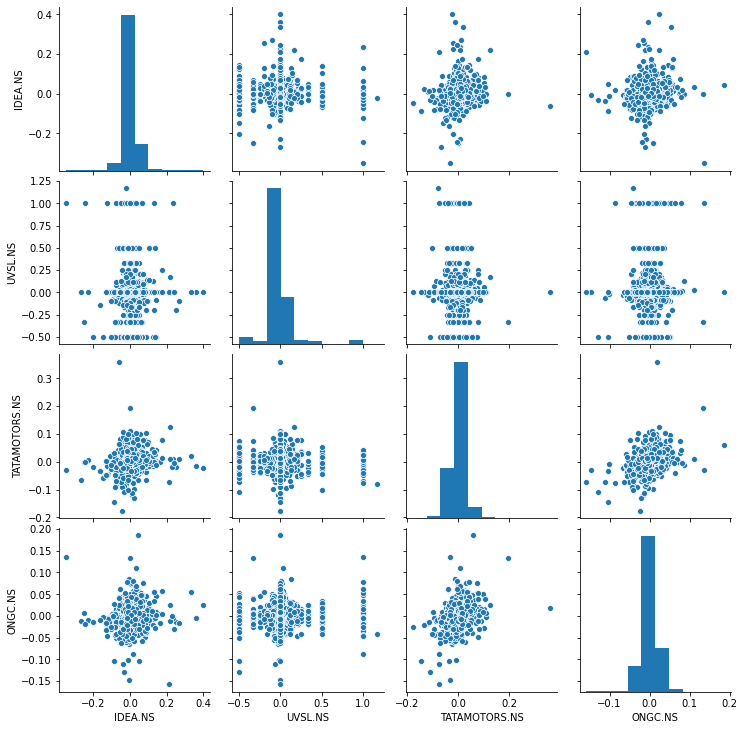

In [7]:
# library & dataset
import seaborn as sns
#plot the data
sns.pairplot(all_data)
plt.show()

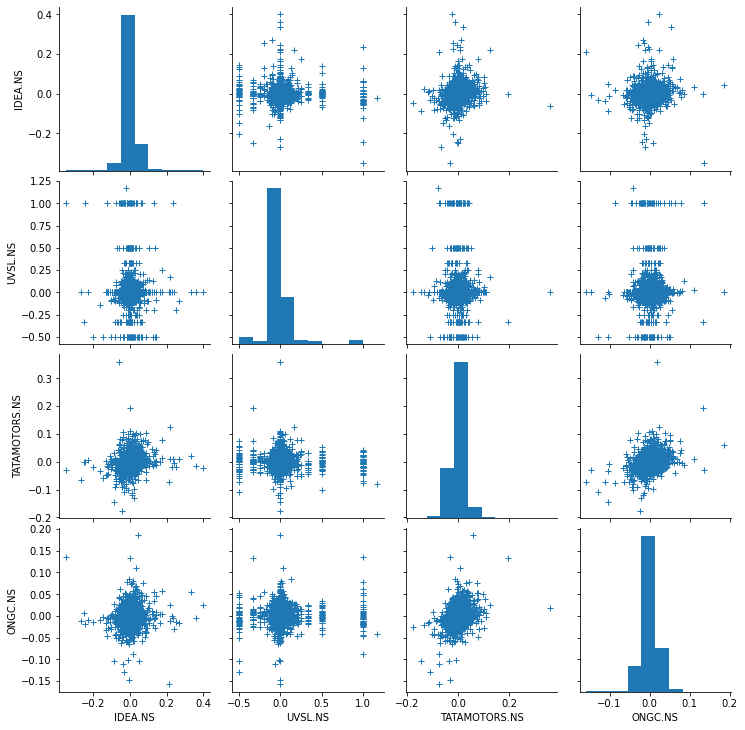

In [13]:
# library & dataset
import seaborn as sns
#sns.pairplot(all_data)
#plt.show()
sns.pairplot(
   all_data,
    plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=True),
)


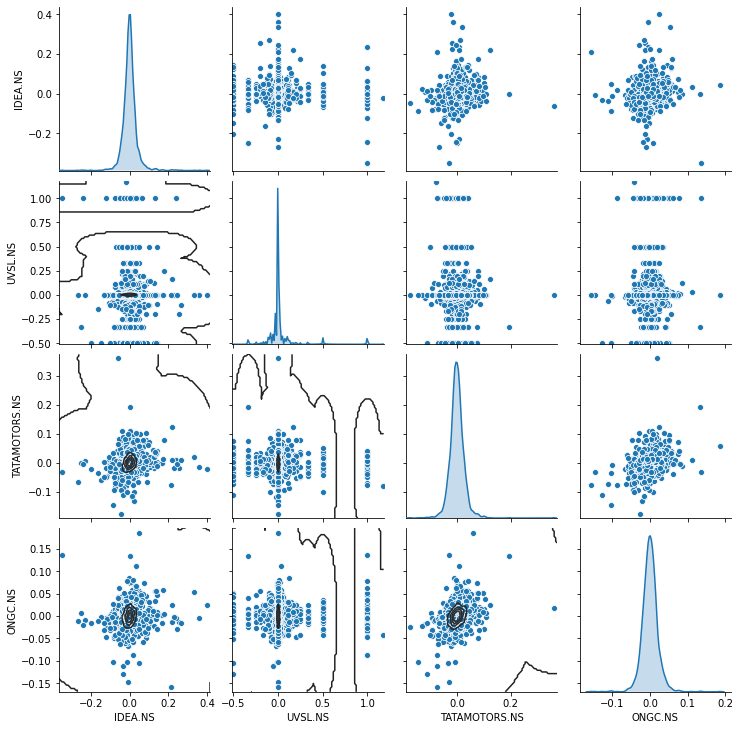

In [15]:
g = sns.pairplot(all_data, diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")
#KDE represents the data using a continuous probability density curve in one or more dimensions.

intercept: 0.0002661693805437499
Slope [0.19916038]
Coefficient of determination: 0.01


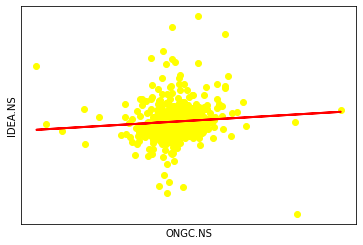

intercept: -0.0002871469637394378
Slope [0.10420377]
Coefficient of determination: -0.01


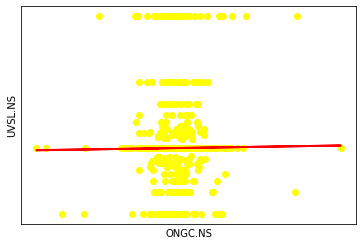

intercept: 0.0005811367231411092
Slope [0.37573917]
Coefficient of determination: 0.14


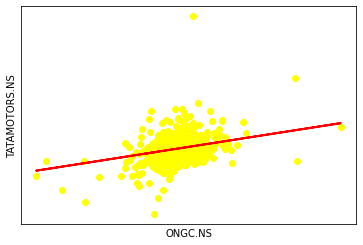

intercept: 5.421010862427522e-20
Slope [1.]
Coefficient of determination: 1.00


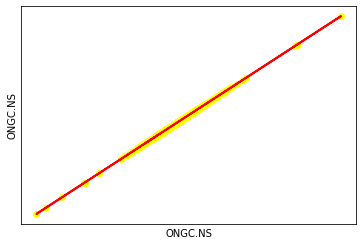

In [16]:
for i in tickers:

    # Split the data into training/testing sets
    X_train = np.array(all_data['ONGC.NS'][:-1000]).reshape(-1,1)
    X_test = np.array(all_data['ONGC.NS'][-750:]).reshape(-1,1)

    # Split the targets into training/testing sets
    Y_train = np.array(all_data[i][:-1000])
    Y_test = np.array(all_data[i][-750:])

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)

    # The coefficients
    print('intercept:', regr.intercept_)
    print('Slope', regr.coef_)

    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'
          % r2_score(Y_test, Y_pred))

    # Plot outputs
    plt.scatter(X_test, Y_test,  color='yellow')
    plt.plot(X_test, Y_pred, color='red', linewidth=2)

    plt.xticks(())
    plt.yticks(())
    plt.xlabel('ONGC.NS')
    plt.ylabel(i)
    plt.show()

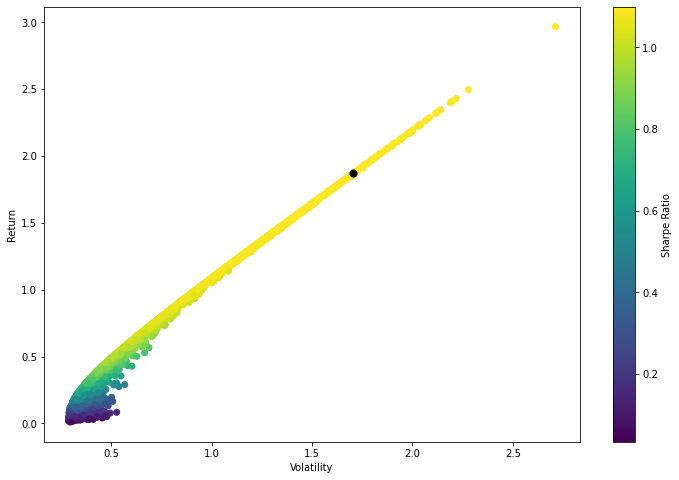

Max Sharpe Ratio is 1.099075488319449
Max Sharpe Ratio is in location 5078


In [17]:
np.random.seed(42)
num_ports = 6000
all_weights = np.zeros((num_ports, len(all_data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (all_data.mean() * weights * 252))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(all_data.cov()*252, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
    
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
plt.scatter(max_sr_vol, max_sr_ret,c='black', s=50) # black dot
plt.show()
print('Max Sharpe Ratio is {}' .format(sharpe_arr.max()))
print('Max Sharpe Ratio is in location {}' .format(sharpe_arr.argmax()))      

In [18]:
all_weights[5565]

array([0.52644673, 0.36415566, 0.09996029, 0.00943732])

In [19]:
tickers

['IDEA.NS', 'UVSL.NS', 'TATAMOTORS.NS', 'ONGC.NS']

In [20]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "INFY.BO TCS.BO  RELIANCE.BO",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  3 of 3 completed
